In [1]:
import torch
from algo_reasoning.src.sampler import CLRSDataset
from pathlib import Path

/Users/ronaldalbert/miniconda3/envs/algo_reasoning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Pretrained Model

In [3]:
from algo_reasoning.src.models.network import EncodeProcessDecode
from algo_reasoning.src.lightning.AlgorithmicReasoningTask import AlgorithmicReasoningTask 
from algo_reasoning.src.specs import CLRS_30_ALGS
from algo_reasoning.src.losses.AlgorithmicReasoningLoss import AlgorithmicReasoningLoss

In [4]:
algorithms = ["optimal_bst"]
regularization = "hidden_reg=0.5"

In [5]:
ckpt_path = str(next(Path(f"../checkpoints/m3/checkpoints/{algorithms[0]}/").glob(f"{algorithms[0]}-{regularization}*")))

model = EncodeProcessDecode(algorithms)
loss_fn = AlgorithmicReasoningLoss()

model = AlgorithmicReasoningTask.load_from_checkpoint(ckpt_path, model=model, loss_fn=loss_fn).model

# Graph Fourier Analysis of Algorithmic Embeddings

## Toy Example: Graph Fourier Transform of BFS Embeddings

In [6]:

def fourier_transform(embeddings, nb_nodes):
    """
    Compute the Fourier Transform of the embeddings.

    Args:
        embeddings: a tensor of shape (batch_size, sequence_length, embedding_dim)

    Returns:
        a tensor of shape (batch_size, sequence_length, embedding_dim)
    """

    laplacian = torch.diag(torch.ones(nb_nodes, device=device)*nb_nodes) - torch.ones((nb_nodes, nb_nodes), device=device)
    result = torch.linalg.eigh(laplacian)
    eigenvalues = result.eigenvalues
    eigenvectors = result.eigenvectors
    
    eigenvalues[torch.isclose(eigenvalues, torch.tensor(0.))] = 0.

    return eigenvectors.T@embeddings, eigenvectors, eigenvalues

In [7]:
# Load dataset
algorithm_args = {
    'p': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}

nb_nodes = 16
ds = CLRSDataset(algorithms, nb_nodes, 200, 1000, seed=7, algorithms_args=algorithm_args)

In [8]:
obj = next(iter(ds)).to(device=device)

In [9]:
obj.max_length

tensor(16)

In [ ]:
output = model(obj)
embeddings = output.hidden_embeddings
embeddings.shape

In [ ]:
fourier_embeddings, eigenvectors, eigenvalues = fourier_transform(embeddings, nb_nodes)

<BarContainer object of 16 artists>

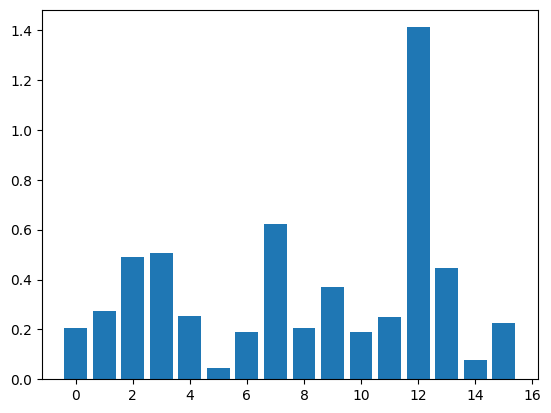

In [ ]:
import matplotlib.pyplot as plt

plot_data = torch.mean(torch.abs(fourier_embeddings), dim=3)

plt.bar(x=[i for i in range(nb_nodes)], height=plot_data[0,0].detach().numpy())

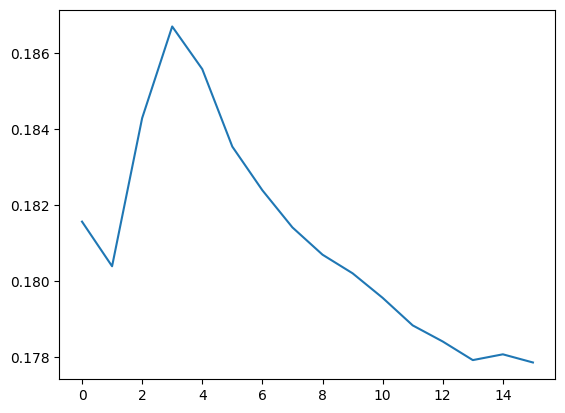

In [ ]:
import matplotlib.pyplot as plt
difference_over_length = torch.mean(torch.abs(plot_data[:, :, 0] - torch.mean(plot_data[:, :, 1:])), dim=0)

plt.plot(difference_over_length.detach().numpy())

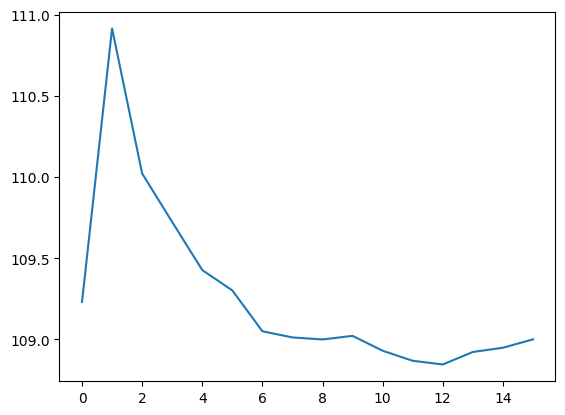

In [ ]:
laplacian = torch.diag(torch.ones(nb_nodes, device=device)*nb_nodes) - torch.ones((nb_nodes, nb_nodes), device=device)
_embeddings = embeddings.clone()[0, :, :]
variability = torch.sum((_embeddings.transpose(1, 2)@laplacian)*_embeddings.transpose(1,2), dim=2)

plt.plot(torch.mean(variability, dim=1).detach().numpy())

In [ ]:
def _mean_corr_coef(embeddings):
    mean_corr_coef = None
    for i in range(embeddings.size(0)):
        if mean_corr_coef is None:
            mean_corr_coef = embeddings[i, 15].corrcoef()
        else:
            mean_corr_coef += embeddings[i, 15].corrcoef()

    mean_corr_coef = mean_corr_coef/embeddings.size(0)

    return mean_corr_coef

In [ ]:
# Calculating embeddings with model reg = 0.0

ckpt_path = str(next(Path(f"../checkpoints/m3/checkpoints/{algorithms[0]}/").glob(f"{algorithms[0]}-hidden_reg=0.0*")))

model = EncodeProcessDecode(algorithms)
loss_fn = AlgorithmicReasoningLoss()

model = AlgorithmicReasoningTask.load_from_checkpoint(ckpt_path, model=model, loss_fn=loss_fn).model

: 

In [ ]:
output = model(obj)
embeddings_0 = output.hidden_embeddings
embeddings_0.shape

### Calculate using pyGSP

In [ ]:
import numpy as np
from pygsp.graphs.fullconnected import FullConnected
from pygsp.graphs.erdosrenyi import ErdosRenyi
from pygsp.graphs.grid2d import Grid2d

G = FullConnected(N=nb_nodes)
G.compute_fourier_basis()

In [ ]:
import matplotlib.pyplot as plt

test_embeddings = embeddings[0, 0,  :, :].detach().numpy()
output  = G.gft(test_embeddings)

plot_data = np.mean(np.abs(output), axis=1)
plt.bar(x=[i for i in range(nb_nodes)], height=plot_data)

In [ ]:
import matplotlib.pyplot as plt

test_embeddings = torch.randn(16, 128)#embeddings[0, 0,  :, :].detach().numpy()
output  = G.gft(test_embeddings)

plot_data = np.mean(np.abs(output), axis=1)
plt.bar(x=[i for i in range(nb_nodes)], height=plot_data)